In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import yfinance as yf             # permet d'utiliser toutes les bases de données de YahooFinance
import statsmodels.api as sm
from scipy.spatial import ConvexHull
from scipy import stats
from scipy.optimize import minimize
from IPython.display import display, Math

plt.rcParams["figure.figsize"] = (8,5)   # Dimensions de figure génériques pour tous les graphiques

In [2]:
# === Indices des marchés de référence ===
MARKETS = {
    # Marché français
    "CAC40": "^FCHI",
    # Marché britannique
    "FTSE": "^FTSE",
    # Marché américain
    "SP500": "^GSPC",
    # Marché suisse
    "SMI": "^SSMI",
    # Marché italien
    "FTSEMIB": "FTSEMIB.MI",
    # Marché chinois
    "CSI300": "000300.SS",
    # Marché allemand
    "DAX": "^GDAXI"
}

# Banque d'actifs variés, avec leurs noms et leur ticker de YahooFinance
ASSETS = {
    # 🇫🇷 ACTIONS FRANÇAISES
    "Thales": "HO.PA",
    "Safran": "SAF.PA",
    "Sanofi": "SAN.PA",
    "Capgemini": "CAP.PA",
    "Alten": "ATE.PA",
    "Air Liquide": "AI.PA",
    "Unibail": "URW.PA",
    "Nexity": "NXI.PA",
    "Klépierre": "LI.PA",
    "Pernod Ricard": "RI.PA",
    "Rémy Cointreau": "RCO.PA",
    "Technip": "TE.PA",
    "Total Energies": "TTE.PA",

    # 🇮🇹 ACTIONS ITALIENNES
    "Stellantis": "STLAM.MI",

    # 🇨🇭 ACTIONS SUISSES
    "Richemont": "CFR.SW",

    # 🇬🇧 ACTIONS UK
    "Burberry": "BRBY.L",
    "Diageo": "DGE.L",
    "Unilever": "ULVR.L",
    "HSBC": "HSBA.L",

    # 🇺🇸 ACTIONS US
    "Tesla": "TSLA",
    "NVIDIA": "NVDA",
    "Microsoft": "MSFT",
    "Apple": "AAPL",
    "Exxon": "XOM",
    "Caterpillar": "CAT",
    "CocaCola": "KO",
    "Procter&Gamble": "PG",
    "Meta": "META",
    "NextEra": "NEE",
    "Intel": "INTC",
    "AMD": "AMD",
    "ASML": "ASML",
    "TSMC": "TSM",
    "Amazon": "AMZN",
    "JP Morgan": "JPM",
    "Alphabet": "GOOGL",
    "First Phosphate": "PHOS.CN",

    # 🇨🇳 ACTIONS CHINOISES
    "Cambricon": "688256.SS",

    # 🇩🇪 ACTIONS ALLEMANDES
    "Mercedes": "MBG.DE"
}

# On renverse les rôles, pour que ça soit plus simple avec l'affichage graphique plus tard
actifs = {v: k for k, v in ASSETS.items()}

tickers_longs = [
    "AMD",
    "Mercedes",
    "Safran",
    "Unibail",
    "Sanofi",
    "Microsoft",
    "Pernod Ricard",
    "TSMC",
    "Richemont",
    "Cambricon",
    "Thales",
    "Air Liquide",
    "NextEra",
    "Amazon",
    "Rémy Cointreau",
    "JP Morgan"
]

tickers_shorts = [
    "ASML",
    "Stellantis",
    "Capgemini",
    "Nexity",
    "Intel",
    "Meta",
    "Technip",
    "Apple",
    "Burberry",
    "NVIDIA",
    "Alten",
    "Klépierre",
    "Tesla",
    "Alphabet",
    "Total Energies",
    "First Phosphate"
]

longs  = [ASSETS[t] for t in tickers_longs]
shorts = [ASSETS[t] for t in tickers_shorts]
tickers = longs + shorts
N = len(tickers)
N_long = N//2
N_short = N//2

# Dates limites pour l'étude
date_debut = "2023-01-31"
date_fin   = "2026-01-31"

In [3]:
""" Fonction qui évalue les actifs individuellement """

def eval_actif(ticker, market):
    data = yf.download([ticker, market], start=date_debut, end=date_fin, auto_adjust=True)["Close"]
    returns = data.pct_change(fill_method=None).dropna()
    #returns = np.log(data / data.shift(1)).dropna()
    vol = returns[ticker].std() * np.sqrt(252)
    Y = returns[ticker]
    X = sm.add_constant(returns[market])
    model = sm.OLS(Y, X).fit()
    beta = model.params[market]
    alpha_annualized = model.params["const"] * 252
    t_alpha = model.tvalues["const"]

    try:
        nom = yf.Ticker(ticker).info["longName"]
    except:
        nom = ticker

    alpha = alpha_annualized
    b = beta
    alpha_cut = 0.03
    
    # --- étape 1 : alpha d'abord ---
    if alpha > alpha_cut:
        classe_alpha = "positive"
    elif alpha < -alpha_cut:
        classe_alpha = "negative"
    else:
        verdict = "NEUTRE (alpha faible)"
        classe_alpha = None
    
    # --- étape 2 : beta filtre ---
    if classe_alpha == "positive":
        if b < 1.0:
            verdict = "LONG (alpha fort, beta maîtrisé)"
        else:
            verdict = "NEUTRE (alpha ok mais trop directionnel)"
    
    elif classe_alpha == "negative":
        if b > 1.0:
            verdict = "SHORT (alpha négatif amplifié)"
        else:
            verdict = "NEUTRE (alpha négatif mais peu exploitable)"

    recap = pd.DataFrame({
        r"Volatilité annuelle $(\%)$": [round(vol * 100, 2)],
        r"$\beta$": [round(beta, 3)],
        r"$\alpha_{annuel} (\%)$": [round(alpha_annualized * 100, 3)],
        r"$t_\alpha$": [round(t_alpha,3)],
        "Verdict": [verdict]
    }, index=[nom])

    return display(recap)

In [4]:
eval_actif(ASSETS["ASML"],MARKETS["SP500"])

[*********************100%***********************]  2 of 2 completed


,Volatilité annuelle $(\%)$,$\beta$,$\alpha_{annuel} (\%)$,$t_\alpha$,Verdict
ASML Holding N.V.,39.52,1.66,3.037,0.17,NEUTRE (alpha ok mais trop directionnel)


In [5]:
eval_actif(ASSETS["Capgemini"],MARKETS["CAC40"])

[*********************100%***********************]  2 of 2 completed


,Volatilité annuelle $(\%)$,$\beta$,$\alpha_{annuel} (\%)$,$t_\alpha$,Verdict
Capgemini SE,27.44,1.052,-9.342,-0.704,SHORT (alpha négatif amplifié)


In [6]:
data = yf.download(
    tickers,
    start=date_debut,
    end=date_fin,
    auto_adjust=True
)["Close"]

data = data.rename(columns=actifs)

[*********************100%***********************]  32 of 32 completed


In [7]:
# Petit affichage de la tête et la queue des données, pour vérifier qu'on a bien toute la plage de dates
print("Aperçu des données :")
print(data.head())
print("\nDernières dates :")
print(data.tail())

Aperçu des données :
Ticker      Cambricon       Apple  Air Liquide        AMD      Amazon  \
Date                                                                    
2023-01-31  62.099998  142.012711   125.875702  75.150002  103.129997   
2023-02-01  64.739998  143.134674   125.530983  84.639999  105.150002   
2023-02-02  69.900002  148.439606   126.427269  88.309998  112.910004   
2023-02-03  71.110001  152.061539   125.237961  86.089996  103.389999   
2023-02-06  72.839996  149.335236   123.790131  83.680000  102.180000   

Ticker            ASML       Alten     Burberry   Capgemini   Richemont  ...  \
Date                                                                     ...   
2023-01-31  642.144470  134.494934  2459.093994  163.781448  130.414719  ...   
2023-02-01  659.333923  136.311157  2419.125000  166.512711  130.554047  ...   
2023-02-02  676.844299  141.472992  2468.086914  177.390656  132.086700  ...   
2023-02-03  660.393250  142.142120  2478.079346  178.002838  133.94

In [8]:
# Calcul des taux d'évolution de rendement JOURNALIERS
returns = data.pct_change(fill_method=None).dropna()

In [9]:
print("Aperçu des rendements :")
print(returns.head())

print("\nStatistiques journalières rapides :")
print(returns.describe())

Aperçu des rendements :
Ticker      Cambricon     Apple  Air Liquide       AMD    Amazon      ASML  \
Date                                                                         
2023-04-17   0.009231  0.000121     0.009845 -0.020490  0.002244 -0.040769   
2023-04-18  -0.005183  0.007505     0.005124 -0.001001 -0.004283  0.006713   
2023-04-19   0.132904  0.006968     0.005222  0.001782  0.019550 -0.030669   
2023-04-20   0.200000 -0.005846     0.003835  0.001890 -0.004698  0.015988   
2023-04-21  -0.068230 -0.009781     0.003697 -0.018644  0.030344  0.001420   

Ticker         Alten  Burberry  Capgemini  Richemont  ...  Rémy Cointreau  \
Date                                                  ...                   
2023-04-17 -0.017415 -0.005012  -0.033798  -0.022386  ...        0.021600   
2023-04-18  0.026585  0.009686   0.020558   0.016746  ...       -0.008000   
2023-04-19 -0.014608 -0.006523  -0.014432   0.005378  ...        0.002304   
2023-04-20 -0.010108  0.010043  -0.021354   

In [10]:
mu = returns.mean() * 252
sigma = returns.std() * np.sqrt(252)
corr = returns.corr()
cov = returns.cov() * 252

mu.index.name = None
sigma.index.name = None
corr.index.name = corr.columns.name = None
cov.index.name = cov.columns.name = None

summary = pd.DataFrame({
    "Rendement annualisé (%)": mu * 100,
    "Volatilité annualisée (%)": sigma * 100
})

summary = summary.round(3)

print("===== SYNTHÈSE RENDEMENT / RISQUE (%) =====")
print(summary.to_string())

print("\n===== MATRICE DE COVARIANCE =====")
print(cov.round(5).to_string())

print("\n===== MATRICE DE CORRÉLATION =====")
print(corr.round(3).to_string())

print("\nCorrélations fortes (|ρ| > 0.45) :")

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        val = corr.iloc[i, j]
        if abs(val) > 0.45:
            print(f"{corr.columns[i]} / {corr.columns[j]} : {val:.3f}")

===== SYNTHÈSE RENDEMENT / RISQUE (%) =====
                 Rendement annualisé (%)  Volatilité annualisée (%)
Cambricon                        133.432                     77.780
Apple                             37.963                     24.999
Air Liquide                       18.132                     16.126
AMD                               51.761                     50.131
Amazon                            48.888                     31.491
ASML                              43.717                     39.534
Alten                              1.018                     35.901
Burberry                          -4.331                     44.848
Capgemini                          8.364                     27.305
Richemont                         28.850                     31.810
Alphabet                          55.831                     30.073
Thales                            29.713                     28.568
Intel                             41.301                     55.000
JP M

In [11]:
""" Constitution d'un portefeuille initial équiréparti qui servira de base à l'optimisation """
w0 = np.zeros(N)
w0[:N_long] = 1/N
w0[N_short:] = -1/N

rendement_portfolio_equi = returns @ w0
rendement_portfolio_equi.name = "Portefeuille équiréparti"


Rendement annuel attendu : 5.26 %
Risque (volatilité) : 6.09 %


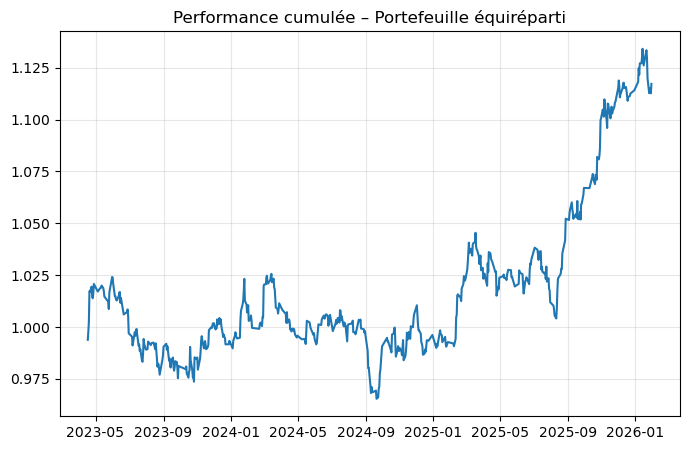

In [12]:
portfolio_return = np.dot(w0, mu)
portfolio_risk = np.sqrt(w0.T @ cov @ w0)
print("\nRendement annuel attendu :", round(portfolio_return * 100, 2), "%")
print("Risque (volatilité) :", round(portfolio_risk * 100, 2), "%")

perf_equi = (1 + rendement_portfolio_equi).cumprod()
plt.plot(perf_equi)
plt.title("Performance cumulée – Portefeuille équiréparti")
plt.grid(True,alpha=0.3)

In [13]:
""" Générations de portefeuilles aléatoires """
n_portfolios = 10000
results = []
weights_list = []
assets = mu.index.tolist()
n = len(assets)

for k in range(n_portfolios):
    w_long = np.random.uniform(0, 1, N_long)
    w_short = np.random.uniform(0, 1, N_short)
    w = np.concatenate([w_long, -w_short])
    w = w / np.sum(np.abs(w))   # exposition brute = 1
    results.append([
        np.sqrt(w.T @ cov @ w),
        w @ mu
    ])
    weights_list.append(w)


results = np.array(results)
risks = results[:, 0]
returns_mc = results[:, 1]

In [14]:
n_steps = 10000   # nombre de proportions long/short
results = []
weights_list = []
long_ratios = np.linspace(0.01, 0.99, n_steps)

for L in long_ratios:
    S = 1 - L
    # répartition aléatoire MAIS normalisée des longs
    w_long_raw = np.random.uniform(0, 1, N_long)
    w_long = L * w_long_raw / np.sum(w_long_raw)
    # répartition aléatoire MAIS normalisée des shorts
    w_short_raw = np.random.uniform(0, 1, N_short)
    w_short = S * w_short_raw / np.sum(w_short_raw)
    w = np.concatenate([w_long, -w_short])
    ret = w @ mu
    risk = np.sqrt(w.T @ cov @ w)
    results.append([risk, ret])
    weights_list.append(w)

results = np.array(results)
risks_mc = results[:,0]
returns_mc = results[:,1]

In [15]:
""" Fonctions génériques et conditions utilisées pour procéder à l'optimisation """
def portfolio_stats_Markowitz(w):
    ret = np.dot(w, mu)
    risk = np.sqrt(w.T @ cov @ w)
    return ret, risk

def neg_sharpe(w):
    ret, risk = portfolio_stats_Markowitz(w)
    return -ret / risk

def f_contrainte(w):
    return (np.sum(np.abs(w)) - 1)

# Conditions au bord pour les longs / shorts
lim_short = (-1, -0.001)
lim_long = (0.001, 1)
limits = [lim_long]*N_long + [lim_short]*N_short

In [16]:
""" Phase d'optimisation : """
condition = [{"type": "eq", "fun": f_contrainte}]
opt = minimize(neg_sharpe, w0, bounds=limits, constraints=condition,method="SLSQP")
w_opt = opt.x
ret_opt, risk_opt = portfolio_stats_Markowitz(w_opt)
sharpe_opt = ret_opt / risk_opt
portfolio_constrained = pd.Series(w_opt, index=assets)

print("===== PORTEFEUILLE OPTIMAL CONTRAINT =====")
print(portfolio_constrained.round(3).to_string())

print("\nRendement (%) :", round(ret_opt*100,2))
print("Risque (%) :", round(risk_opt*100,2))
print("Sharpe :", round(sharpe_opt,3))

===== PORTEFEUILLE OPTIMAL CONTRAINT =====
Cambricon          0.036
Apple              0.034
Air Liquide        0.108
AMD                0.001
Amazon             0.041
ASML               0.001
Alten              0.001
Burberry           0.001
Capgemini          0.019
Richemont          0.046
Alphabet           0.069
Thales             0.040
Intel              0.001
JP Morgan          0.119
Klépierre          0.188
Mercedes           0.033
Meta              -0.001
Microsoft         -0.047
NextEra           -0.006
NVIDIA            -0.001
Nexity            -0.022
First Phosphate   -0.001
Rémy Cointreau    -0.033
Pernod Ricard     -0.085
Safran            -0.001
Sanofi            -0.005
Stellantis        -0.056
Technip           -0.001
Tesla             -0.001
TSMC              -0.001
Total Energies    -0.001
Unibail           -0.001

Rendement (%) : 29.68
Risque (%) : 6.84
Sharpe : 4.337


/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [17]:
def normalize_brut(w):
    return w / np.sum(np.abs(w))

def port_return(w):
    w = normalize_brut(w)
    return w @ mu

def port_risk(w):
    w = normalize_brut(w)
    return np.sqrt(w.T @ cov @ w)

In [18]:
target_returns = np.linspace(ret_opt*0.1, ret_opt*2, 40)

In [19]:
# Générer la frontière efficiente exacte par Markowitz (à chaque rendement, on associe le risque minimal)
frontier_risk = []
frontier_return = []
w_current = w0

for R in target_returns:
    constraint_ret = {"type": "eq", "fun": lambda w, R=R: port_return(w) - R}
    opt = minimize(
        port_risk,
        w_current,
        bounds=limits,
        constraints=[constraint_ret],
        method="SLSQP"
    )
    if opt.success:
        w_star = normalize_brut(opt.x)
        frontier_risk.append(np.sqrt(w_star.T @ cov @ w_star))
        frontier_return.append(w_star @ mu)
        w_current = w_star

/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


In [20]:
# Générer la frontière efficiente empirique, par enveloppe convexe
points = np.column_stack([risks_mc, returns_mc])
hull = ConvexHull(points)

# indices des sommets de l’enveloppe
hull_pts = points[hull.vertices]

# garder uniquement la partie haute (frontière efficiente)
hull_pts = hull_pts[np.argsort(hull_pts[:,0])]   # tri par risque

# optionnel : garder seulement ceux qui montent
front_emp_risk = []
front_emp_return = []

max_ret = -np.inf
for r, ret in hull_pts:
    if ret > max_ret:
        front_emp_risk.append(r)
        front_emp_return.append(ret)
        max_ret = ret

front_emp_risk = np.array(front_emp_risk)
front_emp_return = np.array(front_emp_return)

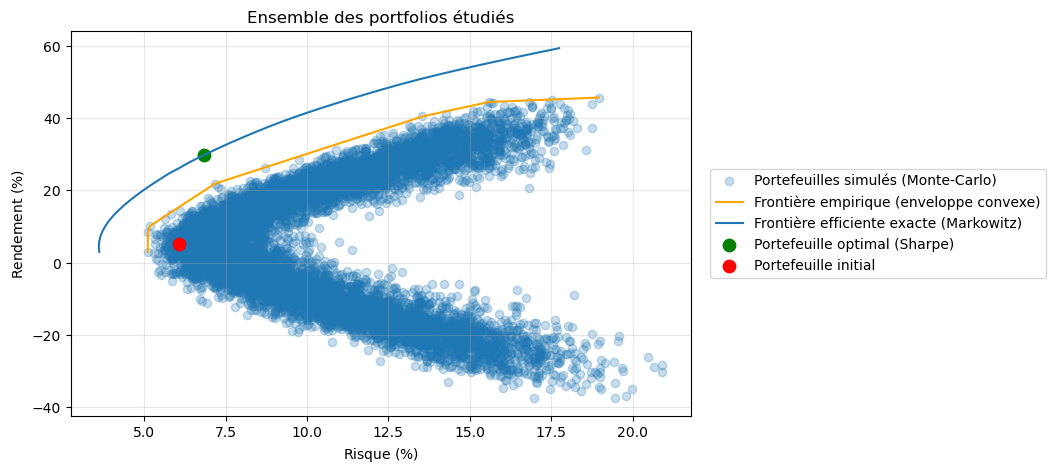

In [21]:
# Nuage Monte-Carlo de portefeuilles simulés
plt.scatter(
    risks_mc*100,
    returns_mc*100,
    alpha=0.25,
    label="Portefeuilles simulés (Monte-Carlo)"
)

# Frontière empirique par enveloppe convexe
plt.plot(
    front_emp_risk*100,
    front_emp_return*100,
    color="orange",
    linewidth=1.5,
    label="Frontière empirique (enveloppe convexe)"
)

# Frontière exacte Markowitz
plt.plot(
    np.array(frontier_risk)*100,
    np.array(frontier_return)*100,
    linewidth=1.5,
    label="Frontière efficiente exacte (Markowitz)"
)

# Portefeuille Sharpe optimal
plt.scatter(
    risk_opt*100,
    ret_opt*100,
    color="green",
    s=80,
    label="Portefeuille optimal (Sharpe)"
)

# Portefeuille initial
plt.scatter(
    portfolio_risk*100,
    portfolio_return*100,
    color="red",
    s=80,
    label="Portefeuille initial"
)

plt.xlabel(r"Risque $(\%)$")
plt.ylabel(r"Rendement $(\%)$")
plt.title("Ensemble des portfolios étudiés")
plt.legend(loc="center left",bbox_to_anchor=(1.02, 0.5),frameon=True)
plt.grid(True,alpha=0.3)
plt.show()

L'écart entre la frontière efficiente et le nuage de points simulés est logique : la simulation est aléatoire donc 
elle a une infime probabilité quasi-nulle de troucher effectivement le portefeuille optimal. Alors que la frontière, quant à elle, est construite de façon exacte avec le critère de Markowitz : pour toute une plage de rendement, on calcule le risque minimal.

In [23]:
# Constitution effective du portefeuille en monnaie réelle
def get_last_price(ticker, date_fin):
    data = yf.download(
        ticker,
        end=date_fin,
        auto_adjust=True,
        progress=False
    )["Close"]

    return data.dropna().iloc[-1].iloc[0]

In [24]:
FX = {
    "USD": "EURUSD=X",
    "GBP": "EURGBP=X",
    "GBp": "EURGBP=X",
    "CHF": "EURCHF=X",
    "CAD": "EURCAD=X",
    "CNY": "EURCNY=X",
    "EUR": None
}

def to_eur(price, currency):
    if currency == "EUR":
        return price
    fx = FX[currency]
    rate = yf.download(fx, period="5d", progress=False)["Close"].dropna().iloc[-1]
    if currency == "GBp":
        price = price / 100   # pence → livre
    return price / rate

In [25]:
budget = 100_000
rows = []
total_invested = 0

for ticker, w in zip(tickers, w_opt):
    info = yf.Ticker(ticker).info
    currency = info.get("currency", "EUR")
    price_raw = get_last_price(ticker, date_fin)
    price_eur = to_eur(price_raw, currency)
    allocation = abs(w) * budget
    ratio = allocation / price_eur

    # convertir proprement si pandas Series
    if isinstance(ratio, pd.Series):
        ratio = ratio.iloc[0]

    n = int(np.floor(ratio))
    amount = n * price_eur

    #n = int(np.floor(float(allocation / price_eur)))
    amount = n * price_eur
    total_invested += amount
    rows.append({
        "Ticker": ticker,
        "Position": "LONG" if w > 0 else "SHORT",
        "Prix (€)": round(price_eur,2),
        "Actions": n,
        "Montant (€)": round(amount,2)
    })

portfolio_real = pd.DataFrame(rows)
def clean_scalar(x):
    if isinstance(x, pd.Series):
        return float(x.iloc[0])
    return float(x)

portfolio_real["Actif"] = portfolio_real["Ticker"].map(actifs)
portfolio_real = portfolio_real[["Actif", "Position", "Prix (€)", "Actions", "Montant (€)"]]
portfolio_real["Prix (€)"] = portfolio_real["Prix (€)"].apply(clean_scalar)
portfolio_real["Montant (€)"] = portfolio_real["Montant (€)"].apply(clean_scalar)
portfolio_real["Actions"] = portfolio_real["Actions"].astype(int)
portfolio_real.index = range(1, len(portfolio_real) + 1)


# Présentation du tableau avec les résultats
longs_table  = portfolio_real[portfolio_real["Position"] == "LONG"].reset_index(drop=True)
shorts_table = portfolio_real[portfolio_real["Position"] == "SHORT"].reset_index(drop=True)
lgt_table = len(longs_table)

longs_table  = longs_table.reindex(range(lgt_table))
shorts_table = shorts_table.reindex(range(lgt_table))
total_long  = longs_table["Montant (€)"].abs().sum()
total_short = shorts_table["Montant (€)"].abs().sum()
longs_table.loc[len(longs_table)] = ["TOTAL", "", "", "", round(total_long,2)]
shorts_table.loc[len(shorts_table)] = ["TOTAL", "", "", "", round(total_short,2)]

portfolio_split = pd.concat([longs_table, shorts_table], axis=1)
portfolio_split.columns = list(longs_table.columns) + list(shorts_table.columns)
display(portfolio_split)

,Actif,Position,Prix (€),Actions,Montant (€),Actif,Position,Prix (€),Actions,Montant (€)
0,AMD,LONG,199.21,17,3386.54,ASML,SHORT,1196.02,0,0.00
1,Mercedes,LONG,57.79,58,3351.82,Stellantis,SHORT,8.29,567,4698.16
2,Safran,LONG,301.0,35,10535.00,Capgemini,SHORT,131.2,4,524.80
3,Unibail,LONG,93.0,1,93.00,Nexity,SHORT,9.55,10,95.50
4,Sanofi,LONG,79.2,52,4118.40,Intel,SHORT,39.11,56,2190.11
5,Microsoft,LONG,362.09,0,0.00,Meta,SHORT,603.01,0,0.00
6,Pernod Ricard,LONG,75.08,1,75.08,Technip,SHORT,33.04,98,3237.92
7,TSMC,LONG,278.17,0,0.00,Apple,SHORT,218.17,39,8508.79
8,Richemont,LONG,163.63,11,1799.88,Burberry,SHORT,12.64,7,88.45
9,Cambricon,LONG,153.53,29,4452.39,NVIDIA,SHORT,160.86,2,321.71


In [26]:
capital_used = total_long + total_short
gross_exposure = capital_used
net_exposure = total_long - total_short
capital_remaining = budget - capital_used

print("Total Long :", round(total_long,2), "€")
print("Total Short :", round(total_short,2), "€")
print("Capital utilisé :", round(capital_used,2), "€")
print("Capital restant:", round(capital_remaining,2), "€")
print("Exposition nette :", round(net_exposure,2), "€")

Total Long : 72219.21 €
Total Short : 25458.1 €
Capital utilisé : 97677.31 €
Capital restant: 2322.69 €
Exposition nette : 46761.11 €


In [27]:
# On re-scale le portfolio pour maximiser le capital utilisé et avoir au moins une action par actif
real_cost = portfolio_real["Montant (€)"].abs().sum()
scale = budget / real_cost
portfolio_real["Montant (€)"] *= scale
portfolio_real["Actions"] = np.floor(portfolio_real["Montant (€)"] / portfolio_real["Prix (€)"]).astype(int)
portfolio_real["Montant (€)"] = (portfolio_real["Actions"] * portfolio_real["Prix (€)"])
real_cost_scaled = portfolio_real["Montant (€)"].abs().sum()
cash_left = round(budget - real_cost_scaled,2)

print("===== RÉCAP PORTFEUILLE =====")
print("Capital total :", budget, "€")
print("Capital investi :", round(real_cost_scaled,2), "€")
print("Cash restant :", cash_left, "€")

total_long  = portfolio_real.loc[
    portfolio_real["Position"]=="LONG","Montant (€)"
].abs().sum()

total_short = portfolio_real.loc[
    portfolio_real["Position"]=="SHORT","Montant (€)"
].abs().sum()

# Présentation du tableau avec les résultats
longs_table  = portfolio_real[portfolio_real["Position"] == "LONG"].reset_index(drop=True)
shorts_table = portfolio_real[portfolio_real["Position"] == "SHORT"].reset_index(drop=True)
lgt_table = len(longs_table)

longs_table  = longs_table.reindex(range(lgt_table))
shorts_table = shorts_table.reindex(range(lgt_table))
total_long  = longs_table["Montant (€)"].abs().sum()
total_short = shorts_table["Montant (€)"].abs().sum()
longs_table.loc[len(longs_table)] = ["", "", "", "", round(total_long,2)]
shorts_table.loc[len(shorts_table)] = ["", "", "", "", round(total_short,2)]

portfolio_split = pd.concat([longs_table, shorts_table], axis=1)
portfolio_split.columns = list(longs_table.columns) + list(shorts_table.columns)

# Pour avoir les indices qui démarrent à 1 au lieu de 0
new_index = list(range(1, len(portfolio_split)))
new_index.append("TOTAL")
portfolio_split.index = new_index
display(portfolio_split)


DEBUG = False
if DEBUG:
    print("\nExposition Long :", round(total_long,2), "€")
    print("Exposition Short :", round(total_short,2), "€")
    print("Exposition brute :", round(total_long + total_short,2), "€")
    print("Exposition nette :", round(total_long - total_short,2), "€")

===== RÉCAP PORTFEUILLE =====
Capital total : 100000 €
Capital investi : 98756.07 €
Cash restant : 1243.93 €


,Actif,Position,Prix (€),Actions,Montant (€),Actif,Position,Prix (€),Actions,Montant (€)
1,AMD,LONG,199.21,17,3386.57,ASML,SHORT,1196.02,0,0.00
2,Mercedes,LONG,57.79,59,3409.61,Stellantis,SHORT,8.29,580,4808.20
3,Safran,LONG,301.0,35,10535.00,Capgemini,SHORT,131.2,4,524.80
4,Unibail,LONG,93.0,1,93.00,Nexity,SHORT,9.55,10,95.50
5,Sanofi,LONG,79.2,53,4197.60,Intel,SHORT,39.11,57,2229.27
6,Microsoft,LONG,362.09,0,0.00,Meta,SHORT,603.01,0,0.00
7,Pernod Ricard,LONG,75.08,1,75.08,Technip,SHORT,33.04,100,3304.00
8,TSMC,LONG,278.17,0,0.00,Apple,SHORT,218.17,39,8508.63
9,Richemont,LONG,163.63,11,1799.93,Burberry,SHORT,12.64,7,88.48
10,Cambricon,LONG,153.53,29,4452.37,NVIDIA,SHORT,160.86,2,321.72


In [28]:
# Régression CAPM pour le portfeuille

# === Mapping actif → marché ===
ASSET_MARKET = {
    "Apple":"SP500","AMD":"SP500","Amazon":"SP500","Alphabet":"SP500",
    "JP Morgan":"SP500","Microsoft":"SP500","Meta":"SP500",
    "NVIDIA":"SP500","Tesla":"SP500","NextEra":"SP500","TSMC":"SP500",

    "Air Liquide":"CAC40","Alten":"CAC40","Capgemini":"CAC40","Thales":"CAC40",
    "Sanofi":"CAC40","Rémy Cointreau":"CAC40","Pernod Ricard":"CAC40",
    "Total Energies":"CAC40","Technip":"CAC40","Klépierre":"CAC40",
    "Nexity":"CAC40","Unibail":"CAC40",

    "Richemont":"SMI",
    "Burberry":"FTSE",
    "Stellantis":"FTSEMIB",
    "Mercedes":"DAX",

    "Cambricon":"CSI300",
    "First Phosphate":"SP500"
}

# === Exposition par marché (pondérée par |w|) ===
weights_market = {}
for asset, w in portfolio_constrained.items():
    mkt = ASSET_MARKET.get(asset)
    if mkt:
        weights_market[mkt] = weights_market.get(mkt, 0) + abs(w)

# Normalisation
total = sum(weights_market.values())
weights_market = {k: v/total for k,v in weights_market.items()}

#print("Poids par marché :")
#print(weights_market)

# === Télécharger indices ===
market_prices = yf.download(
    [MARKETS[m] for m in weights_market],
    start=date_debut,
    end=date_fin,
    auto_adjust=True,
    progress=False
)["Close"]

market_returns = market_prices.pct_change(fill_method=None).dropna()

# === Construire rendement marché composite ===
r_m = sum(weights_market[m] * market_returns[MARKETS[m]]for m in weights_market)
r_m.name = "Poids des marchés du portfolio"

Estimation CAPM : $$ (R_p - R_f) = \alpha + \beta(R_m - R_f) + \underbrace{\varepsilon}_{\text{bruit}} $$

In [30]:
r_p = returns @ portfolio_constrained
r_f = pd.Series(0.03/252, index=r_p.index) # taux annuel de 3% sans risque
Y = r_p - r_f
X = r_m - r_f
data_capm = pd.concat([r_p - r_f, r_m - r_f], axis=1).dropna()
data_capm.columns = ["Rp_minus_Rf", "Rm_minus_Rf"]
Y_clean = data_capm["Rp_minus_Rf"]
X_clean = sm.add_constant(data_capm["Rm_minus_Rf"])
X_clean.columns = ["alpha", "beta"]
model = sm.OLS(Y_clean, X_clean).fit()

In [31]:
def run_capm_model(model):
    alpha = model.params["alpha"]
    beta  = model.params["beta"]
    t_alpha = model.tvalues["alpha"]
    t_beta  = model.tvalues["beta"]
    p_alpha = model.pvalues["alpha"]
    p_beta  = model.pvalues["beta"]
    r2 = model.rsquared
    alpha_annual = alpha * 252
    results = pd.DataFrame({
        "Daily": [alpha, beta],
        "Annual": [alpha_annual, np.nan],
        r"$t$-stat": [t_alpha, t_beta],
        r"$p$-value": [p_alpha, p_beta]
    }, index=[r"$\alpha$", r"$\beta$"])

    def tex(x):
        if pd.isna(x):
            return ""
        return rf"${x:.4f}$"

    styled = (
        results.style
        .format(tex)
        .set_caption("Coefficients du CAPM")
        .set_properties(**{"text-align": "center"})
    )

    display(styled)
    display(Math(r"R^2 = " + f"{r2:.4f}"))

In [67]:
run_capm_model(model)

,Daily,Annual,$t$-stat,$p$-value
$\alpha$,$0.0009$,$0.2160$,$5.0653$,$0.0000$
$\beta$,$0.2687$,,$10.4148$,$0.0000$


<IPython.core.display.Math object>

In [116]:
def convert_prices_to_eur(tickers, start_date, end_date):

    prices = yf.download(tickers, start=start_date, end=end_date)["Close"]
    entry = prices.iloc[0]
    exit  = prices.iloc[-1]

    fx = yf.download(["USDEUR=X", "GBPEUR=X", "CHFEUR=X"],start=start_date,end=end_date)["Close"]
    fx_entry = fx.iloc[0]
    fx_exit  = fx.iloc[-1]
    rows = []

    for ticker in tickers:
        p0 = float(entry[ticker])
        p1 = float(exit[ticker])

        # 👉 devise par suffixe
        if ticker.endswith(".SW"):
            p0_eur = p0 * fx_entry["CHFEUR=X"]
            p1_eur = p1 * fx_exit["CHFEUR=X"]

        elif ticker.endswith(".L"):   # UK
            p0_eur = p0 * fx_entry["GBPEUR=X"]
            p1_eur = p1 * fx_exit["GBPEUR=X"]

            # 🔥 correction pence automatique
            if p0_eur > 200:   # Burberry ne vaut pas 1600€
                p0_eur /= 100
                p1_eur /= 100

        elif ticker.endswith(".PA") or ticker.endswith(".DE") or ticker.endswith(".MI"):
            p0_eur, p1_eur = p0, p1

        else:  # US
            p0_eur = p0 * fx_entry["USDEUR=X"]
            p1_eur = p1 * fx_exit["USDEUR=X"]

        rows.append([p0_eur, p1_eur])

    df = pd.DataFrame(rows,index=tickers,columns=["Prix entrée (€)", "Prix sortie (€)"])
    return df.round(2)

In [120]:
assets = ["ASML", "AMD", "CFR.SW", "BRBY.L"]
display(convert_prices_to_eur(assets,"2024-01-10","2026-02-12"))

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  3 of 3 completed


,Prix entrée (€),Prix sortie (€)
ASML,644.33,1207.47
AMD,135.87,179.64
CFR.SW,115.36,175.17
BRBY.L,16.30,13.80


In [124]:
# Test de quelques évolutions de prix
assets_courts = ["TSLA","NVDA","MSFT","AAPL","XOM","CAT","KO","PG","META","NEE","INTC","AMD","ASML","TSM","AMZN","JPM","GOOGL","PHOS.CN"]
display(convert_prices_to_eur(assets_courts,"2024-01-10","2026-02-12"))

[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  3 of 3 completed


,Prix entrée (€),Prix sortie (€)
TSLA,213.99,360.21
NVDA,49.69,159.85
MSFT,344.98,340.10
AAPL,168.56,231.71
XOM,84.20,130.84
CAT,259.56,651.83
KO,51.90,66.11
PG,129.46,134.57
META,336.52,562.42
NEE,53.68,76.84
